In [1]:
import pandas as pd
import re
import os 
import keras
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.models import Model


In [2]:
#Hyperparameter

MAX_SEQUENCE_LENGTH = 300
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [4]:
data_train = pd.read_csv("/content/FA-KES-Dataset.csv", encoding ='ISO-8859-1')
data_train.head()

,unit_id,article_title,article_content,source,date,location,labels
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0


In [5]:
texts = []
labels = []
for i in range(data_train.article_content.shape[0]):
    text1 = data_train.article_title[i]
    text2 = data_train.article_content[i]
    text = str(text1) +""+ str(text2)
    texts.append(text)
    labels.append(data_train.labels[i])

News = pd.DataFrame()    
News['text'] = texts
News['label'] = labels
News

,text,label
0,Syria attack symptoms consistent with nerve ag...,0
1,Homs governor says U.S. attack caused deaths b...,0
2,Death toll from Aleppo bomb attack at least 11...,0
3,Aleppo bomb blast kills six Syrian state TVWed...,0
4,29 Syria Rebels Dead in Fighting for Key Alepp...,0
...,...,...
799,Turkish Bombardment Kills 20 Civilians in Syri...,1
800,Martyrs as Terrorists Shell Aleppos Salah Eddi...,1
801,Chemical Attack Kills Five Syrians in Aleppo S...,0
802,5 Killed as Russian Military Chopper Shot down...,1


In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
def pre_process_news(news):
    
    lemm = WordNetLemmatizer()
    ps = PorterStemmer() 
    stop_words = set(stopwords.words('english'))
    news = news.lower()
    news = re.sub("[^0-9a-z]", ' ' , news) # removes punctuations
    news = re.sub(r"http\S+", "", news)
    tokenized = news.split(" ")
    news = [ ps.stem(word) for word in tokenized if word not in stop_words] # apply stemming and drop stopwords
    news = " ".join(news)  # join the tokens into a string
    news = lemm.lemmatize(news)  
    return news
News['processed_text'] = News['text'].apply(lambda news : pre_process_news(news))
data = News["processed_text"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [7]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = ' ')
tokenizer.fit_on_texts(texts = data)
sequences = tokenizer.texts_to_sequences(texts = data)
word_index = tokenizer.word_index

In [8]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = keras.utils.to_categorical(np.asarray(labels),num_classes = 2)
labels = np.asarray(labels)

In [9]:
from sklearn.model_selection import train_test_split
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( x_test, y_test, test_size=0.50, random_state=42)  

In [10]:
y_train = np.array([np.argmax(y, axis=None, out=None) for y in y_train], dtype=np.float32)
y_test = np.array([np.argmax(y, axis=None, out=None) for y in y_test], dtype=np.float32)


In [11]:
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.20, random_state=42)


In [12]:
!rm -r ~/.kaggle
! mkdir ~/.kaggle
from google.colab import files
files.upload() 
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download danielwillgeorge/glove6b100dtxt

rm: cannot remove '/root/.kaggle': No such file or directory


Saving kaggle.json to kaggle.json
 94% 123M/131M [00:01<00:00, 94.1MB/s]
100% 131M/131M [00:01<00:00, 87.9MB/s]


In [13]:
! unzip glove6b100dtxt

Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [14]:
from keras.models import Sequential
from matplotlib import pyplot as plt

%matplotlib inline

#Using Pre-trained word embeddings: GLOVE Method
GLOVE_DIR = "/content" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    vecs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = vecs
f.close()
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH)


In [15]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
EPOCHS = 10
# CNN-RNN Model
modell = Sequential()
modell.add(embedding_layer)
modell.add(Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(LSTM(100, dropout=0.2))
modell.add(BatchNormalization())
modell.add(Dense(32, activation='relu'))
modell.add(Dense(1, activation='sigmoid'))
modell.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m, precision_m, recall_m])
print(modell.summary())
history=modell.fit(x_train, y_train, epochs=EPOCHS, batch_size=64, validation_data=(x_valid, y_valid))

modell.save('lstm.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          797600    
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 148, 128)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                3

In [17]:
loss, acc, f1_score, precision, recall = modell.evaluate(x_test, y_test, verbose=0)
print(f"\n LOSS: {loss},\n\n ACCURACY: {acc},\n\n F1_SCORE: {f1_score},\n\n PRECISION: {precision},\n\n RECALL: {recall}\n")


 LOSS: 0.7606476545333862,

 ACCURACY: 0.46875,

 F1_SCORE: 0.5863247513771057,

 PRECISION: 0.4743589758872986,

 RECALL: 0.7960526347160339



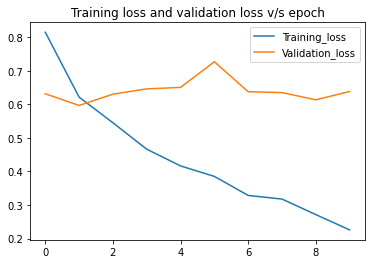

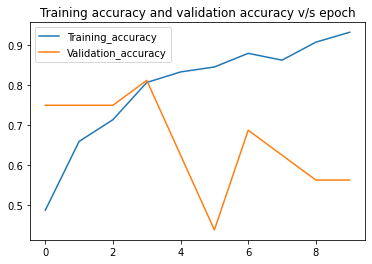

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(range(EPOCHS),history.history['loss'])
plt.plot(range(EPOCHS),history.history['val_loss'])
plt.title("Training loss and validation loss v/s epoch")
plt.legend(["Training_loss","Validation_loss"])

plt.figure()

plt.plot(range(EPOCHS),history.history['accuracy'])
plt.plot(range(EPOCHS),history.history['val_accuracy'])
plt.title("Training accuracy and validation accuracy v/s epoch")
plt.legend(["Training_accuracy","Validation_accuracy"])

In [19]:
# RNN_MODEL
EPOCHS = 10
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100, dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m, precision_m, recall_m])
print(model.summary())
history_rnn=model.fit(x_train, y_train, epochs=EPOCHS, batch_size=64, validation_data=(x_valid,y_valid))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          797600    
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 64)                6464      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 884,529
Trainable params: 884,529
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
11/11 [=========================

In [20]:
loss_rnn, acc_rnn, f1_score_rnn, precision_rnn, recall_rnn = model.evaluate(x_test, y_test, verbose=0)
print(f"\n LOSS: {loss_rnn},\n\n ACCURACY: {acc_rnn},\n\n F1_SCORE: {f1_score_rnn},\n\n PRECISION: {precision_rnn},\n\n RECALL: {recall_rnn}\n")


 LOSS: 0.93572598695755,

 ACCURACY: 0.46875,

 F1_SCORE: 0.4554554224014282,

 PRECISION: 0.444444477558136,

 RECALL: 0.4714912176132202



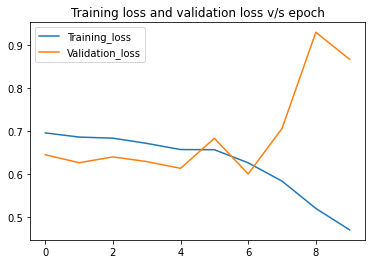

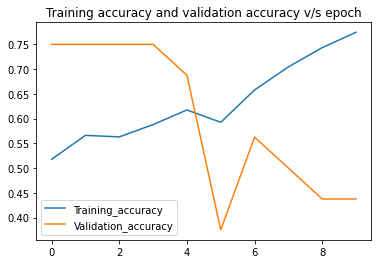

In [21]:
plt.plot(range(EPOCHS),history_rnn.history['loss'])
plt.plot(range(EPOCHS),history_rnn.history['val_loss'])
plt.title("Training loss and validation loss v/s epoch")
plt.legend(["Training_loss","Validation_loss"])

plt.figure()
plt.plot(range(EPOCHS),history_rnn.history['accuracy'])
plt.plot(range(EPOCHS),history_rnn.history['val_accuracy'])
plt.title("Training accuracy and validation accuracy v/s epoch")
plt.legend(["Training_accuracy","Validation_accuracy"])
